# Cell 1: imports and basic setup

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import joblib

# sentiment tool
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sns.set(style="whitegrid")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/swatidixit/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


load data (auto-detect csv or xlsx)

In [14]:
for fname in ['test.csv', 'test.xlsx', 'data/test.csv', 'data/test.xlsx']:
    if os.path.exists(fname):
        file_path = fname
        break
else:
    raise FileNotFoundError("Put test.csv or test.xlsx in the project folder and re-run.")

print("Loading:", file_path)
if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
else:
    df = pd.read_excel(file_path)

print("Rows,cols:", df.shape)
df.head(5)

Loading: test.xlsx
Rows,cols: (2191, 4)


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


Detect important column names (date / text / employee)

In [15]:
# Cell 3: auto-detect likely date / text / employee columns
cols = df.columns.tolist()
date_cols = [c for c in cols if 'date' in c.lower() or 'time' in c.lower()]
text_cols = [c for c in cols if any(k in c.lower() for k in ['msg','message','text','body','content'])]
emp_cols  = [c for c in cols if any(k in c.lower() for k in ['employee','emp','sender','from','userid','name'])]

print("Detected date columns:", date_cols)
print("Detected text columns:", text_cols)
print("Detected employee columns:", emp_cols)

# pick defaults (adjust manually if needed)
date_col  = date_cols[0]  if date_cols else input("Enter the date column name: ")
text_col  = text_cols[0]  if text_cols else input("Enter the text/message column name: ")
employee_col = emp_cols[0] if emp_cols else input("Enter the employee id/name column: ")

# Ensure types
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df[text_col] = df[text_col].astype(str)

print("Using date col:", date_col, "text col:", text_col, "employee col:", employee_col)


Detected date columns: ['date']
Detected text columns: ['body']
Detected employee columns: ['from']
Using date col: date text col: body employee col: from


Sentiment labeling (VADER, reproducible thresholds)

In [17]:
# Cell 4: sentiment labeling using VADER
# Thresholds: compound >= 0.05 -> Positive; <= -0.05 -> Negative; else Neutral
def label_sentiment_vader(text):
    s = sid.polarity_scores(str(text))['compound']
    if s >= 0.05:
        return 'Positive'
    elif s <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df[text_col].apply(label_sentiment_vader)
df['score'] = df['sentiment'].map({'Positive':1, 'Negative':-1, 'Neutral':0})
df['msg_len'] = df[text_col].str.len()

# Save labeled file
df.to_csv('labeled_data.csv', index=False)
print("Saved labeled_data.csv — sample:")
df[[employee_col, date_col, text_col, 'sentiment']].head(6)


Saved labeled_data.csv — sample:


,from,date,body,sentiment
0,sally.beck@enron.com,2010-05-10,EnronOptions Announcement\n\n\nWe have updated...,Positive
1,eric.bass@enron.com,2010-07-29,"Marc,\n\nUnfortunately, today is not going to ...",Positive
2,sally.beck@enron.com,2011-07-25,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral
3,johnny.palmer@enron.com,2010-03-25,we were thinking papasitos (we can meet somewh...,Neutral
4,lydia.delgado@enron.com,2011-05-21,Since you never gave me the $20 for the last t...,Positive
5,eric.bass@enron.com,2011-10-23,"sure, just call me the bank that delivers.\n \...",Positive


Cell 5 — EDA (counts, basic visuals)

sentiment
Positive    1528
Neutral      511
Negative     152
Name: count, dtype: int64


sentiment
Positive    0.697398
Neutral     0.233227
Negative    0.069375
Name: proportion, dtype: float64

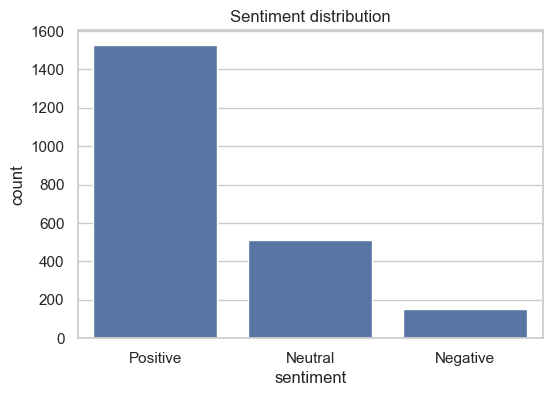

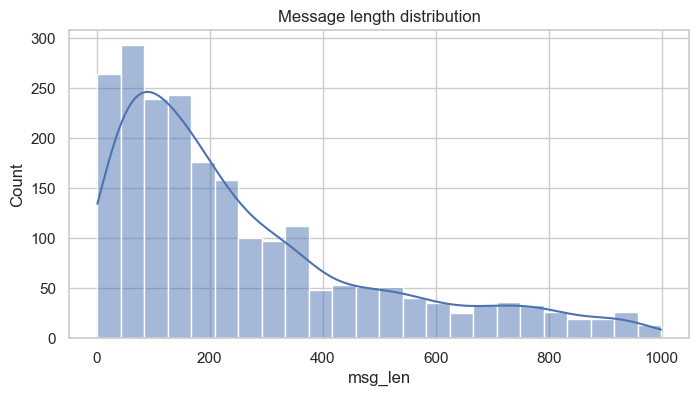

In [18]:
# Cell 5: EDA basics
import matplotlib.ticker as ticker

# 1) value counts
print(df['sentiment'].value_counts())
display(df['sentiment'].value_counts(normalize=True))

# 2) sentiment distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=['Positive','Neutral','Negative'])
plt.title('Sentiment distribution')
plt.savefig('visualizations/sentiment_distribution.png', bbox_inches='tight')
plt.show()

# 3) message length distribution
plt.figure(figsize=(8,4))
sns.histplot(df['msg_len'].dropna(), kde=True)
plt.title('Message length distribution')
plt.savefig('visualizations/message_length_hist.png', bbox_inches='tight')
plt.show()


Cell 6 — Monthly sentiment scoring (per employee)

In [19]:
# Cell 6: Monthly scoring per employee
df['month'] = df[date_col].dt.to_period('M').astype(str)  # e.g. "2025-08"
monthly_emp = df.groupby([employee_col, 'month']).agg(
    score=('score','sum'),
    message_count=('score','count'),
    avg_len=('msg_len','mean'),
    pos_count=('sentiment', lambda s: (s=='Positive').sum()),
    neg_count=('sentiment', lambda s: (s=='Negative').sum()),
    neutral_count=('sentiment', lambda s: (s=='Neutral').sum())
).reset_index()

monthly_emp.to_csv('monthly_employee_scores.csv', index=False)
monthly_emp.head()


,from,month,score,message_count,avg_len,pos_count,neg_count,neutral_count
0,bobette.riner@ipgdirect.com,2010-01,1,2,115.000000,1,0,1
1,bobette.riner@ipgdirect.com,2010-02,7,14,295.714286,8,1,5
2,bobette.riner@ipgdirect.com,2010-03,6,11,286.181818,7,1,3
3,bobette.riner@ipgdirect.com,2010-04,3,6,226.500000,3,0,3
4,bobette.riner@ipgdirect.com,2010-05,2,4,172.250000,2,0,2


Cell 7 — Employee ranking (top 3 positive & top 3 negative per month)

In [20]:
# Cell 7: ranking top 3 positive and top 3 negative per month
top3_pos = []
top3_neg = []
for m, g in monthly_emp.groupby('month'):
    pos = g.sort_values(['score', employee_col], ascending=[False, True]).head(3)
    neg = g.sort_values(['score', employee_col], ascending=[True, True]).head(3)
    top3_pos.append((m, pos))
    top3_neg.append((m, neg))

# create nicely formatted output
rankings = []
for m,pos in top3_pos:
    for i, row in pos.iterrows():
        rankings.append({'month': m, 'rank_type':'top_positive', 'employee': row[employee_col], 'score':row['score']})
for m,neg in top3_neg:
    for i, row in neg.iterrows():
        rankings.append({'month': m, 'rank_type':'top_negative', 'employee': row[employee_col], 'score':row['score']})

rank_df = pd.DataFrame(rankings)
rank_df.to_csv('employee_rankings.csv', index=False)
rank_df.head(12)


,month,rank_type,employee,score
0,2010-01,top_positive,kayne.coulter@enron.com,13
1,2010-01,top_positive,eric.bass@enron.com,9
2,2010-01,top_positive,lydia.delgado@enron.com,9
3,2010-02,top_positive,john.arnold@enron.com,11
4,2010-02,top_positive,johnny.palmer@enron.com,10
5,2010-02,top_positive,bobette.riner@ipgdirect.com,7
6,2010-03,top_positive,sally.beck@enron.com,11
7,2010-03,top_positive,john.arnold@enron.com,7
8,2010-03,top_positive,bobette.riner@ipgdirect.com,6
9,2010-04,top_positive,don.baughman@enron.com,9


Cell 8 — Flight risk identification (rolling 30-day negative message count)

In [21]:
# Cell 8: flight risk - rolling 30 day negative message counts per employee
df2 = df[[employee_col, date_col, 'sentiment', 'msg_len']].copy()
df2['neg_flag'] = (df2['sentiment'] == 'Negative').astype(int)

def compute_30d_rolling(df_in, emp_col, date_col):
    rows = []
    for emp, g in df_in.groupby(emp_col):
        g = g.sort_values(date_col).set_index(date_col)
        # rolling window over 30 days
        g['neg_30d'] = g['neg_flag'].rolling('30D').sum().astype(int)
        g = g.reset_index()
        g[emp_col] = emp
        rows.append(g)
    return pd.concat(rows, ignore_index=True)

df_rolled = compute_30d_rolling(df2, employee_col, date_col)
df_rolled.to_csv('employee_30d_rolling_negative_counts.csv', index=False)

# flight risk: any record where neg_30d >= 4 -> unique employees flagged
flight_risks = df_rolled[df_rolled['neg_30d'] >= 4][employee_col].unique().tolist()
print("Flight risk (unique employees):", flight_risks)
# Save list
pd.DataFrame({'employee': flight_risks}).to_csv('flight_risks.csv', index=False)


Flight risk (unique employees): ['bobette.riner@ipgdirect.com', 'don.baughman@enron.com', 'johnny.palmer@enron.com', 'sally.beck@enron.com']


Cell 9 — Predictive modeling (linear regression for sentiment score)

In [11]:
# Cell 9: linear regression to predict monthly sentiment score
# use monthly_emp (employee-month aggregates)
X = monthly_emp[['message_count','avg_len','pos_count','neg_count','neutral_count']].fillna(0)
y = monthly_emp['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# model coefficients
coef_df = pd.DataFrame({'feature': X.columns, 'coef': model.coef_})
coef_df = coef_df.sort_values('coef', ascending=False)
print(coef_df)

# Save model and metrics
joblib.dump(model, 'sentiment_trend_lr_model.joblib')
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).to_csv('model_predictions.csv', index=False)


MSE: 2.137330286709549e-28
R2: 1.0
         feature          coef
2      pos_count  1.000000e+00
0  message_count  8.247496e-16
1        avg_len  1.387779e-16
4  neutral_count  8.908637e-17
3      neg_count -1.000000e+00


Cell 10 — Save visuals & finish

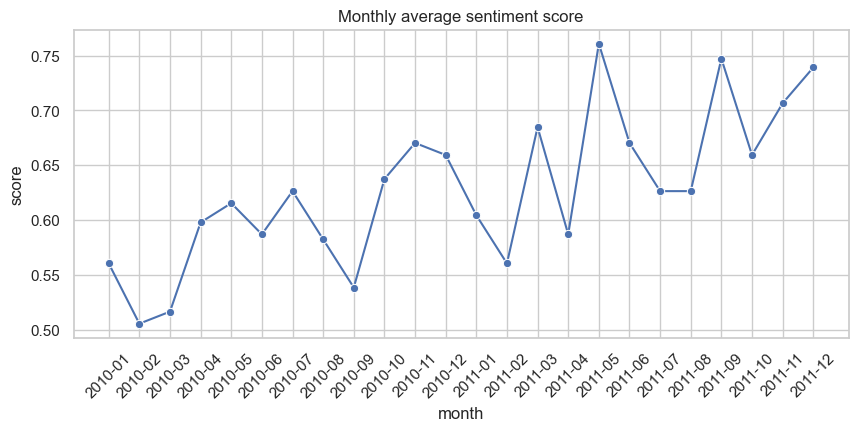

Files saved:
- labeled_data.csv exists? True
- monthly_employee_scores.csv exists? True
- employee_rankings.csv exists? True
- flight_risks.csv exists? True
- sentiment_trend_lr_model.joblib exists? True


In [12]:
# Cell 10: create a summary plot of monthly average sentiment score
monthly_score_ts = df.groupby('month')['score'].mean().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(data=monthly_score_ts, x='month', y='score', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly average sentiment score')
plt.savefig('visualizations/monthly_avg_sentiment.png', bbox_inches='tight')
plt.show()

print("Files saved:")
for f in ['labeled_data.csv', 'monthly_employee_scores.csv', 'employee_rankings.csv', 'flight_risks.csv', 'sentiment_trend_lr_model.joblib']:
    print("-", f, "exists?" , os.path.exists(f))
